In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [117]:
df_train = pd.read_csv('train.csv', index_col='Id')
df_test = pd.read_csv('test.csv', index_col='Id')
combined_data_list = [df_train, df_test]
combined_data = pd.concat([df_train.drop(columns='SalePrice'), df_test])

In [118]:
def isnull_stats(df, isnull_text_addition):
    df = pd.DataFrame(df.isnull().sum())/df.shape[0] * 100
    df = df.reset_index()
    df.columns = ['feature', 'isnull_' + isnull_text_addition + '_%']
    df['isnull_' + isnull_text_addition + '_%'] = df['isnull_' + isnull_text_addition + '_%'].apply(lambda x: int(x*100) / 100)
    df = df[df['isnull_' + isnull_text_addition + '_%']!=0].sort_values('isnull_' + isnull_text_addition + '_%', ascending=False)
    return df

def isnull_train_test_stats(df_train, df_test):
    df_train_missing_values = isnull_stats(df=df_train, isnull_text_addition='train')
    df_test_missing_values = isnull_stats(df=df_test, isnull_text_addition='test')
    df_together_missing_values = df_train_missing_values.merge(df_test_missing_values, on='feature', how='outer').fillna(0)
    col_names = df_together_missing_values.columns
    df_together_missing_values['abs_diff_%'] = abs(df_together_missing_values[col_names[1]] - df_together_missing_values[col_names[2]])

    df_dtypes = df_train.dtypes.reset_index()
    df_dtypes.columns = ['feature', 'dtype']

    df_together_missing_values = df_together_missing_values.merge(df_dtypes, on='feature')

    return df_together_missing_values

df_missing_values = isnull_train_test_stats(df_train, df_test)

In [119]:
def dealing_with_missing_values(df_missing_values, combined_data, missing_val_threshold, gen_number_fillna, gen_obj_fillna):
    values_to_drop_due_threshold = df_missing_values[df_missing_values['isnull_train_%'] >= missing_val_threshold*100]
    values_to_drop_due_threshold = list(values_to_drop_due_threshold.feature)
    print('drop due threshhold ' + str(missing_val_threshold) + ': ', values_to_drop_due_threshold)
    df_missing_values_below_threshold = df_missing_values[~df_missing_values['feature'].isin(values_to_drop_due_threshold)]

    obj_colnames = df_missing_values_below_threshold[df_missing_values_below_threshold['dtype'] == 'object'].feature

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_colnames = combined_data.select_dtypes(include=numerics).columns    

    if gen_obj_fillna == 'most_freq':
        obj_col_fillna_dict = {}
        for col_name in obj_colnames:
          obj_col_fillna_dict[col_name] = combined_data[col_name].value_counts().reset_index().loc[0, 'index']
    else:
        print('there is no method like this:', gen_obj_fillna)
        return

    if gen_number_fillna == 'median':
        num_col_fillna_dict = {}
        for col_name in num_colnames:
          num_col_fillna_dict[col_name] = combined_data[col_name].median()
    elif gen_number_fillna == 'mean':
        num_col_fillna_dict = {}
        for col_name in num_colnames:
          num_col_fillna_dict[col_name] = combined_data[col_name].mean()
    else:
        print('there is no method like this:', gen_number_fillna)
        return

    dict_for_missing_values = obj_col_fillna_dict | num_col_fillna_dict
    df_missing_values['fillna_value'] = df_missing_values['feature'].map(dict_for_missing_values)
    return df_missing_values

df_missing_values = dealing_with_missing_values(df_missing_values, combined_data, missing_val_threshold=0.7, gen_number_fillna='mean', gen_obj_fillna='most_freq')

drop due threshhold 0.7:  ['PoolQC', 'MiscFeature', 'Alley', 'Fence']


In [120]:
def fill_missing_values(df, df_missing_values):
    for feature in df_missing_values.feature:
        if ~pd.isnull(df_missing_values[df_missing_values['feature'] == feature]['fillna_value']).iloc[0]:
            fillna_val = df_missing_values[df_missing_values['feature'] == feature]['fillna_value'].iloc[0]
            df[feature] = df[feature].fillna(fillna_val)
        else:
            df = df.drop(columns=feature)

    return df

df_train = fill_missing_values(df_train, df_missing_values)
df_test = fill_missing_values(df_test, df_missing_values)

[('OverallQual', 'GarageCars'), ('YearBuilt', 'GarageYrBlt'), ('YearRemodAdd', 'GarageYrBlt'), ('BsmtFinSF1', 'BsmtFullBath'), ('TotalBsmtSF', '1stFlrSF'), ('2ndFlrSF', 'GrLivArea'), ('2ndFlrSF', 'HalfBath'), ('2ndFlrSF', 'TotRmsAbvGrd'), ('GrLivArea', 'FullBath'), ('GrLivArea', 'TotRmsAbvGrd'), ('BedroomAbvGr', 'TotRmsAbvGrd'), ('GarageCars', 'GarageArea')]


<AxesSubplot:>

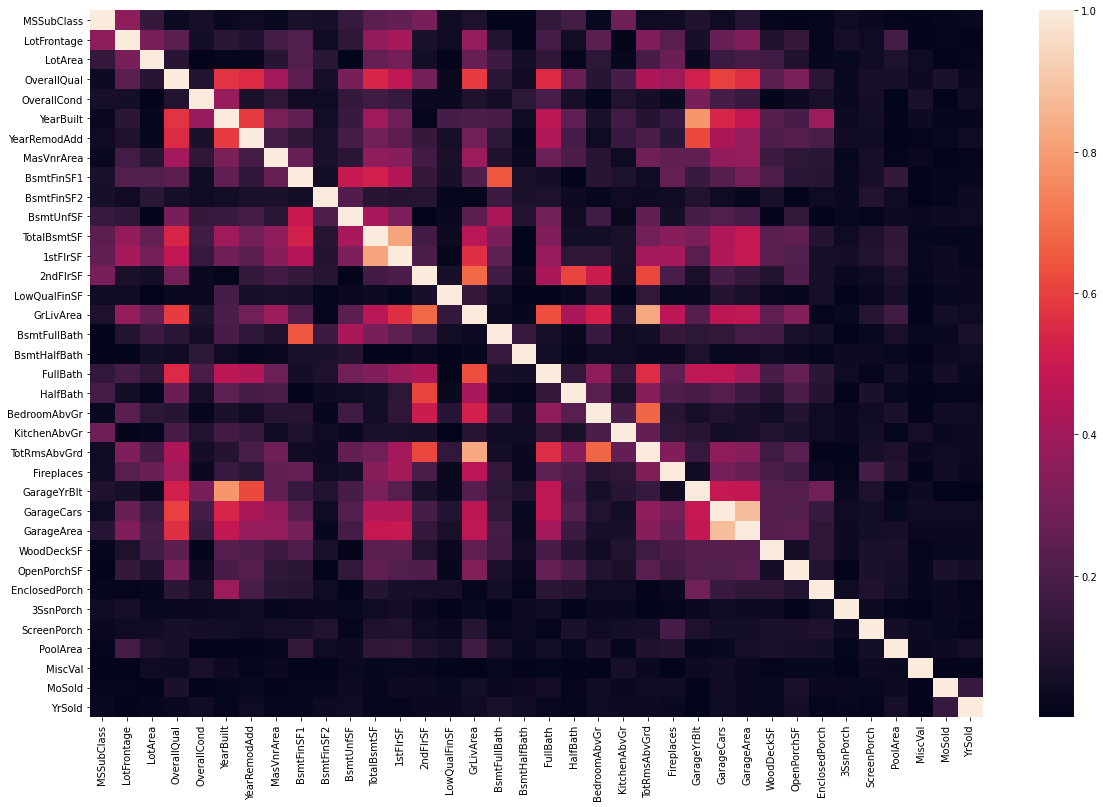

In [121]:
corr_matrix = df_train[list(df_train.columns)[:len(list(df_train.columns))-1]].corr()

corr_matrix = corr_matrix.abs()

high_corr_var=np.where(corr_matrix>0.6)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

print(high_corr_var)


fig, ax = plt.subplots(figsize=(20,13))         # Sample figsize in inches
sns.heatmap(corr_matrix)

In [122]:
corr_with_target = df_train.corr().abs()['SalePrice']
elements_to_exclude = []


for corr_pair in high_corr_var:
    el_1 = corr_pair[0]
    el_2 = corr_pair[1]
    if el_1 in elements_to_exclude or el_2 in elements_to_exclude:
        continue
    else:
        if corr_with_target[el_1] > corr_with_target[el_2]:
            # print('el_1', el_1, 'el_2', el_2, 'corr_with_target[el_1]', corr_with_target[el_1], 'corr_with_target[el_2]', corr_with_target[el_2], 'удаляем ' + str(el_2))
            elements_to_exclude.append(el_2)
        else:
            # print('el_1', el_1, 'el_2', el_2, 'corr_with_target[el_1]', corr_with_target[el_1], 'corr_with_target[el_2]', corr_with_target[el_2], 'удаляем ' + str(el_1))
            elements_to_exclude.append(el_1)

df_train = df_train.drop(columns=elements_to_exclude)
df_test = df_test.drop(columns=elements_to_exclude)

# Преобразование object

In [123]:
def get_object_col_vc(df):
    df_dtypes = df.dtypes.reset_index()
    df_dtypes.columns = ['feature', 'dtype']

    df_obj_dtypes = df_dtypes[df_dtypes['dtype'] == 'object']
    new_df = pd.DataFrame()

    for obj_col in df_obj_dtypes['feature']:
        df[obj_col] = df[obj_col].astype('category')

    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

    return df

df_train = get_object_col_vc(df_train)
df_test = get_object_col_vc(df_test)

# Модель

In [132]:
import xgboost
from sklearn.model_selection import train_test_split  
from sklearn import metrics
XGBReg = xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [149]:
X = df_train[list(df_train.columns)[:len(list(df_train.columns))-1]]
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [150]:
XGBReg = XGBReg.fit(X_train, y_train)

In [151]:
xgb_predictions = XGBReg.predict(X_test)

In [137]:
metrics.mean_squared_log_error(xgb_predictions, y_test)

0.017647488953819887

In [138]:
final_predictions = XGBReg.predict(df_test)

In [139]:
final_predictions

array([136258.9 , 153962.34, 194048.88, ..., 166153.97, 125332.45,
       224143.14], dtype=float32)

In [140]:
df_test['SalePrice'] = final_predictions

In [141]:
df_test[['SalePrice']].to_csv('first_rough_attempt.csv')

In [160]:
df_metrics_check = pd.DataFrame(y_test)
df_metrics_check['y_pred'] = xgb_predictions

In [162]:
df_metrics_check['SalePrice'] = df_metrics_check['SalePrice'].apply(lambda x : np.log(x))
df_metrics_check['y_pred'] = df_metrics_check['y_pred'].apply(lambda x : np.log(x))
df_metrics_check

,SalePrice,y_pred
Id,,
893,11.947949,11.867184
1106,12.691580,12.744714
414,11.652687,11.650138
523,11.976659,12.002505
1037,12.661914,12.737470
...,...,...
332,11.842229,11.833409
324,11.745425,11.615232
651,12.235389,12.308908


In [163]:
metrics.mean_squared_error(df_metrics_check['SalePrice'], df_metrics_check['y_pred'])

0.017647815844609886

In [177]:
def mistake_prob(amt_mistakes, mistake_prob):
    for i in range(amt_mistakes):
        if i == 0:
            not_mistake = 1 - mistake_prob[i]
        else:
            not_mistake *= (1 - mistake_prob[i])

    return 1 - not_mistake

for i in range(1, 6):
    print(mistake_prob(amt_mistakes=i, mistake_prob=[0.1, 0.1, 0.5, 0.1, 0.1]))

0.09999999999999998
0.18999999999999995
0.595
0.6355
0.6719499999999999
